In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date


In [2]:
# Define the ticker symbol
tickerSymbol = 'SOXL'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())

In [3]:
CL = history['Low'].shift(-1) / history['Close'] - 1
print(f'{tickerSymbol} Close to next Low median {CL.median():.2%}')

SOXL Close to next Low median -8.47%


In [4]:
max_weeks = 50

gap = (5/205)*100
option_prices = {
    1: [24.2],
    2: [15.9],
    3: [12.9],
    4: [11],
    5: [9.8],
    6: [8.9],
    7: [8.3],
    8: [7.7],
    9: [7.5],
    10: [6.9],
    11: [7.1],
    12: [6.4],
    13: [6.1] ,
}
print('option leverages:')
for w in option_prices:
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}
print('mean option leverage, break even:')
for w in option_leverage:
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

option leverages:
	 1w 24.2
	 2w 15.9
	 3w 12.9
	 4w 11.0
	 5w  9.8
	 6w  8.9
	 7w  8.3
	 8w  7.7
	 9w  7.5
	10w  6.9
	11w  7.1
	12w  6.4
	13w  6.1
mean option leverage, break even:
	 1w 24.2  6.6%
	 2w 15.9  8.7%
	 3w 12.9 10.2%
	 4w 11.0 11.5%
	 5w  9.8 12.6%
	 6w  8.9 13.7%
	 7w  8.3 14.5%
	 8w  7.7 15.4%
	 9w  7.5 15.8%
	10w  6.9 16.9%
	11w  7.1 16.5%
	12w  6.4 18.1%
	13w  6.1 18.8%
option gap: 2.44%


In [5]:
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median()  * 52 / weeks) # annualized

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        positive_percent = (option_profits > 0).mean() * 100
        option_performance.append([weeks, mean_profit, positive_percent])
        history[f'Option {weeks}w'] = option_profits # ? * 52 / weeks # annualized

In [6]:
print('Option performance (weeks, profit (p.a.), positive):')
for p in option_performance:
    print(f'\t{p[0]:2}w {p[1]:4.0f}% {p[2]:3.0f}%')

Option performance (weeks, profit (p.a.), positive):
	 1w    7%  31%
	 2w   12%  32%
	 3w   23%  33%
	 4w   21%  31%
	 5w   23%  32%
	 6w   22%  32%
	 7w   21%  35%
	 8w   19%  37%
	 9w   23%  38%
	10w   20%  38%
	11w   32%  39%
	12w   29%  39%
	13w   33%  37%


In [7]:
from file import save_file

save_file(tickerSymbol, option_performance)

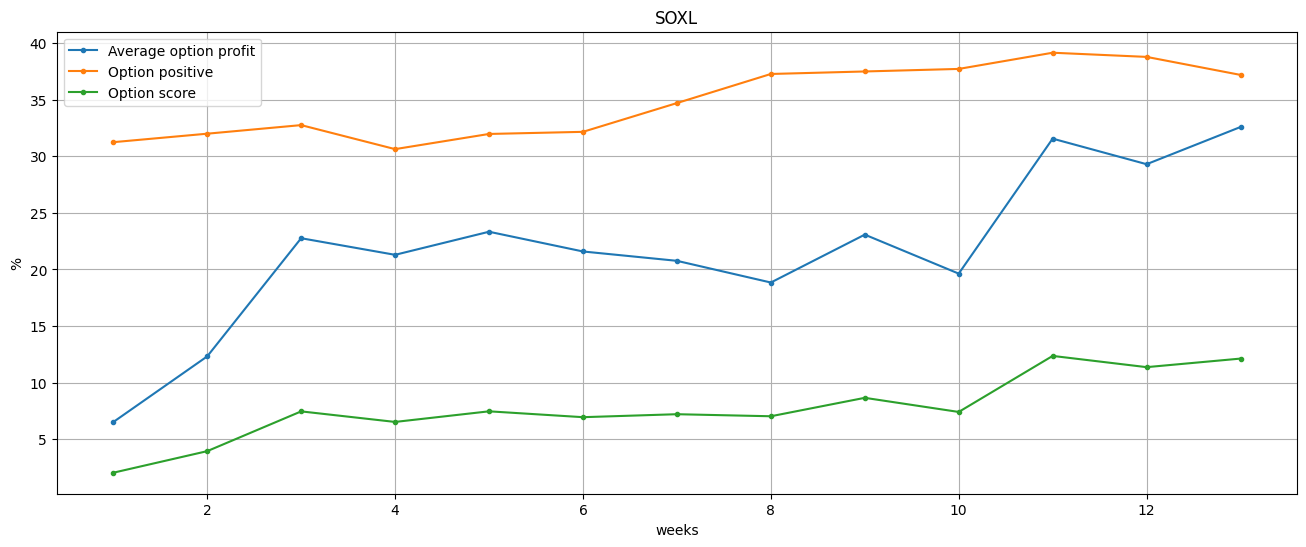

In [8]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.legend(loc='upper left')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

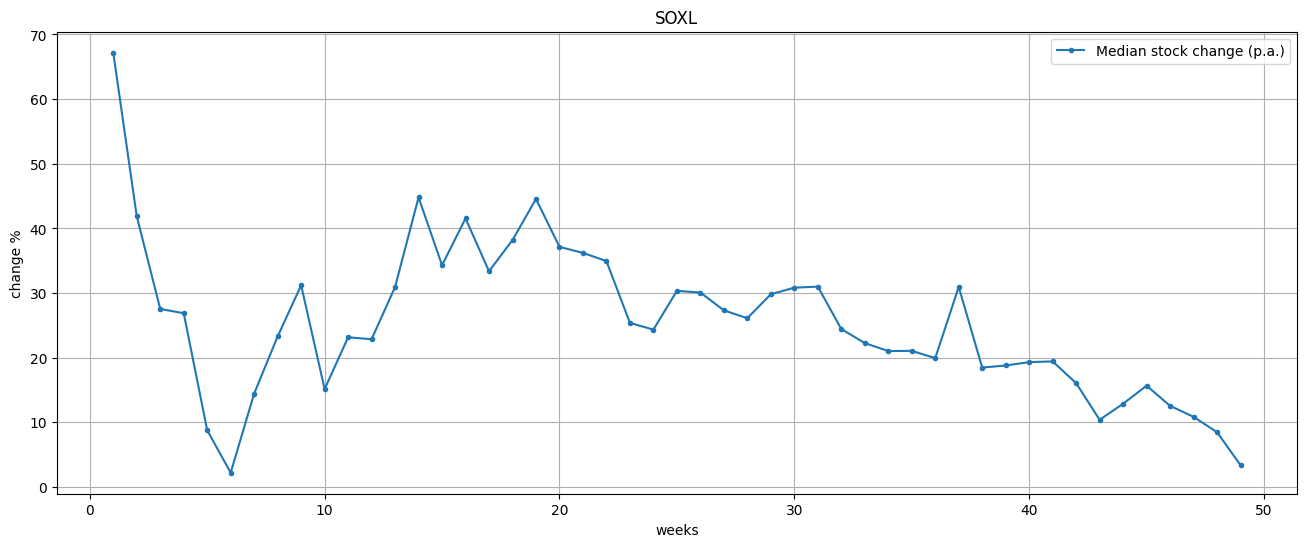

In [9]:
opt = [c * option_leverage[w] - 100 * 52 / w if w in option_leverage else None for w, c in enumerate(stock_change)]

plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Median stock change (p.a.)', marker='.')
# plt.plot(opt, label='Median option gain (p.a.)', marker='.')
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


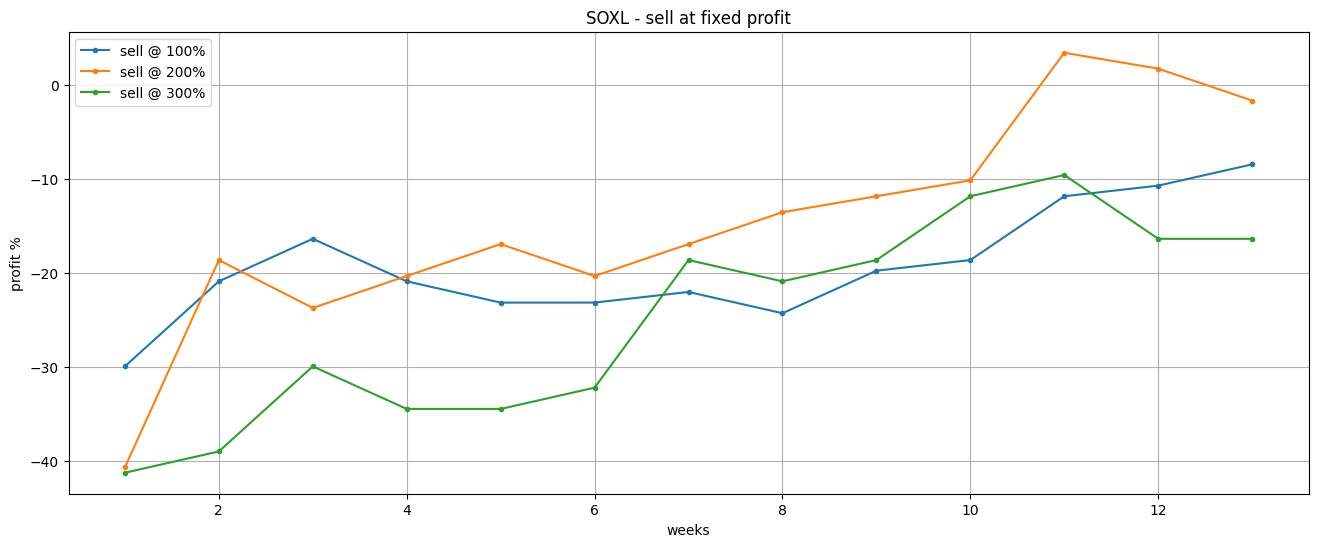

In [10]:
plt.figure(figsize=(16,6))

for percent in [100,200,300]:
    data = {}
    for weeks in range(1, max_weeks+1):
        stock_changes = history['Close'].pct_change(periods=weeks) * 100
        window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

        if weeks in option_leverage:
            lvr = option_leverage[weeks]
            wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
            q = (wmax >= percent).mean()
            data[weeks] = q * (percent + 100) - 100

    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {percent}%', marker='.')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - sell at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()